**APPENDIX I**

In [ ]:
!pip install keras-hypetune

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import random
 
import statsmodels.api as sm
 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
 
# Import Keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM
 
# Import Prophet
from fbprophet import Prophet
# Import VAR Model
from statsmodels.tsa.vector_ar.var_model import VAR
 
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.tsa.vector_ar.var_model import VAR

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from kerashypetune import KerasRandomSearch, KerasGridSearch

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
import numpy
import pandas
from matplotlib import pyplot 
from math import sqrt
from datetime import datetime
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import seaborn as sns

In [ ]:

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras import backend as K
from kerashypetune import KerasGridSearch

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [ ]:
df = pd.read_csv('Aotizhongxin1 - Copy (3) - Copy.csv')
df['date'] = pd.to_datetime(df[['year','month','day','hour']])

print(df.shape)
df.head()

(35064, 17)


,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,date
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,2013-03-01 00:00:00
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,2013-03-01 01:00:00
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,2013-03-01 02:00:00
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,2013-03-01 03:00:00
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,2013-03-01 04:00:00


In [ ]:

df.drop(['No','year','month','day','hour'], axis=1, inplace=True)
df.head()

,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,WSPM,date
0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,4.4,2013-03-01 00:00:00
1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,4.7,2013-03-01 01:00:00
2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,5.6,2013-03-01 02:00:00
3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,3.1,2013-03-01 03:00:00
4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,2.0,2013-03-01 04:00:00


In [ ]:
### ADJUST AND CLEAN DATA ###

df_external = pd.DataFrame(df.index)

for col in df.columns:
    
    if df[col].dtype == object: # correct type
        df[col] = pd.to_numeric(df[col].str.replace(',', '.'))
    
    df[col] = df[col].replace(-200, np.nan) # check nans
    print(col, ':', df[col].isna().sum()/len(df))
    if df[col][:int(len(df)*0.8)].isna().sum()/int(len(df)*0.8) > 0.5: # at least 50% in train not nan
        df.drop(col, axis=1, inplace=True)
    else:
        df[col] = df[col].interpolate(method='linear', limit_direction='both') # fill nans
        
    if col in ['TEMP','RAIN','date']:
        df_external[col] = df[col].values
        df.drop(col, axis=1, inplace=True)

PM2.5 : 0.0
PM10 : 0.0
SO2 : 0.0
NO2 : 0.0
CO : 0.0
O3 : 0.0
TEMP : 0.0
PRES : 0.0
DEWP : 0.0
RAIN : 0.0
WSPM : 0.0
date : 0.0


In [ ]:
df_external.head()

,0,TEMP,RAIN,date
0,0,-0.7,0.0,2013-03-01 00:00:00
1,1,-1.1,0.0,2013-03-01 01:00:00
2,2,-1.1,0.0,2013-03-01 02:00:00
3,3,-1.4,0.0,2013-03-01 03:00:00
4,4,-2.0,0.0,2013-03-01 04:00:00


In [ ]:

### UTILITY FUNCTION FOR CYCLICAL ENCODE VARIABLES ###

def cycle_encode(data, cols):
    
    for col in cols:
        
        data[col + '_sin'] = np.sin(2 * np.pi * data[col]/data[col].max())
        data[col + '_cos'] = np.cos(2 * np.pi * data[col]/data[col].max())
        
    return data

In [ ]:
df_external['month'] = df_external.date.dt.month
df_external['day'] = df_external.date.dt.dayofweek
df_external['hour'] = df_external.date.dt.hour

df_external = cycle_encode(df_external, ['month','day','hour'])
df_external.drop(['month','day','hour'], axis=1, inplace=True)
df_external.set_index('date', inplace=True)

print(df_external.shape)
df_external.head()

(35064, 9)


,0,TEMP,RAIN,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos
date,,,,,,,,,
2013-03-01 00:00:00,0,-0.7,0.0,1.0,6.123234e-17,-0.866025,-0.5,0.000000,1.000000
2013-03-01 01:00:00,1,-1.1,0.0,1.0,6.123234e-17,-0.866025,-0.5,0.269797,0.962917
2013-03-01 02:00:00,2,-1.1,0.0,1.0,6.123234e-17,-0.866025,-0.5,0.519584,0.854419
2013-03-01 03:00:00,3,-1.4,0.0,1.0,6.123234e-17,-0.866025,-0.5,0.730836,0.682553
2013-03-01 04:00:00,4,-2.0,0.0,1.0,6.123234e-17,-0.866025,-0.5,0.887885,0.460065


In [ ]:
### SPLIT TRAIN TEST ###

train, test = train_test_split(df, shuffle=False, train_size=0.8)
train_ext, test_ext = train_test_split(df_external, shuffle=False, train_size=0.8)

print(train.shape, test.shape)
print(train_ext.shape, test_ext.shape)

(28051, 9) (7013, 9)
(28051, 9) (7013, 9)


In [ ]:

### PLOTTING UTILITY FUNCTIONS ###

def plot_sensor(name):
    
    plt.figure(figsize=(16,4))

    plt.plot(train.index, train[name], label='train')
    plt.plot(test.index, test[name], label='test')
    plt.ylabel(name); plt.legend()
    plt.show()
    
def plot_autocor(name, df):
    
    plt.figure(figsize=(16,4))
    
    # pd.plotting.autocorrelation_plot(df[name])
    # plt.title(name)
    # plt.show()
    
    timeLags = np.arange(1,100*24)
    plt.plot([df[name].autocorr(dt) for dt in timeLags])
    plt.title(name); plt.ylabel('autocorr'); plt.xlabel('time lags')
    plt.show()

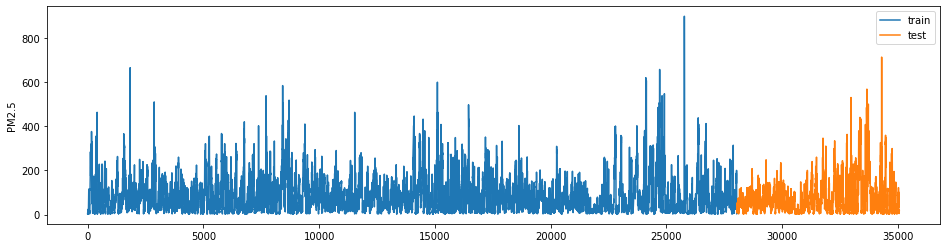

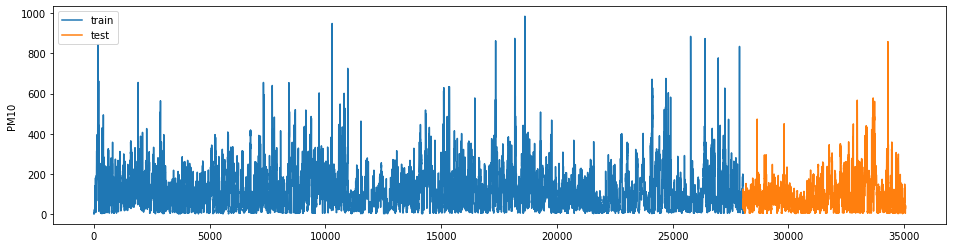

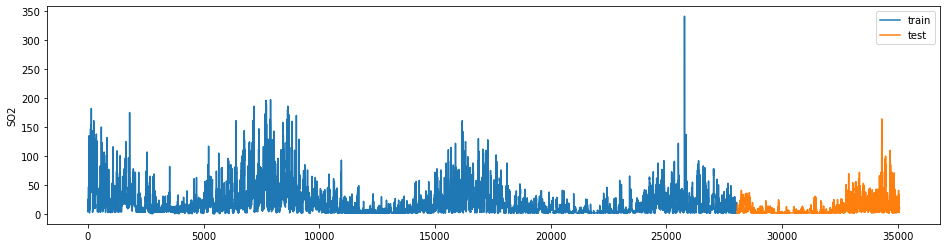

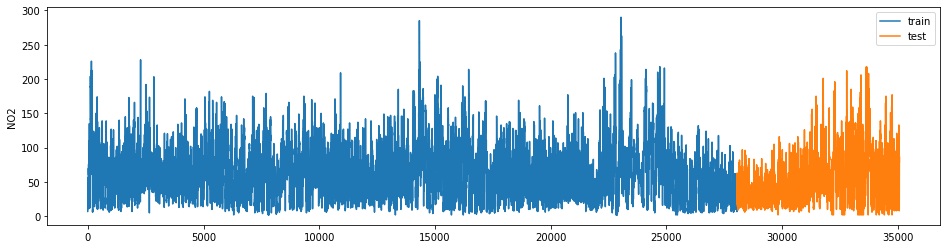

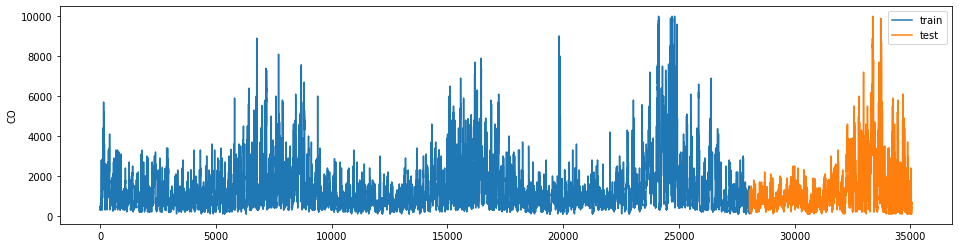

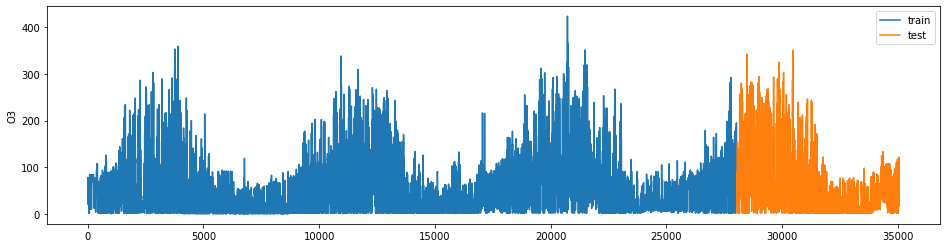

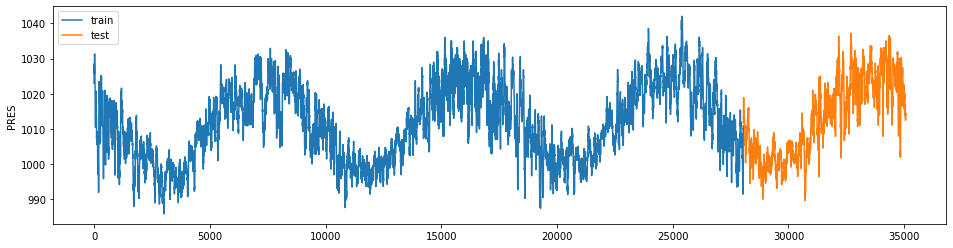

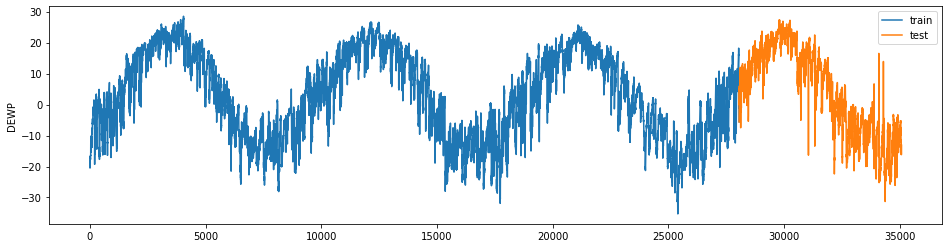

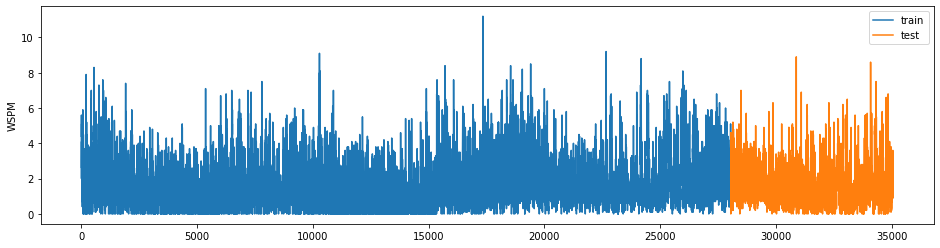

In [ ]:
### PLOT ORIGINAL SERIES ###

for col in df.columns:
    plot_sensor(col)

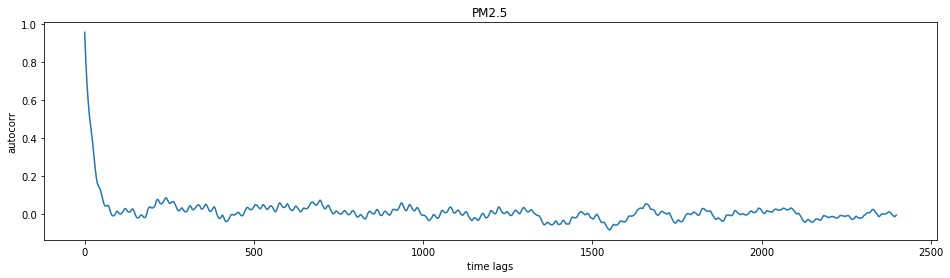

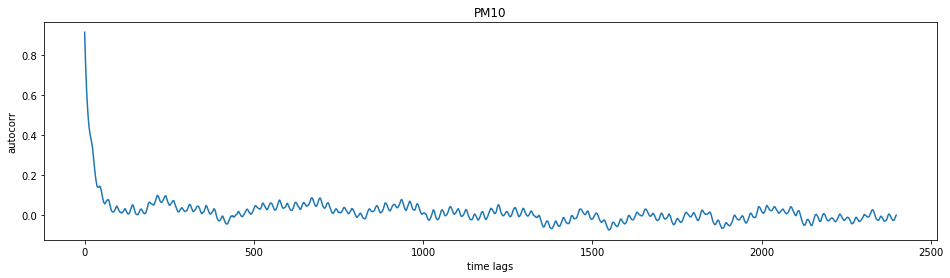

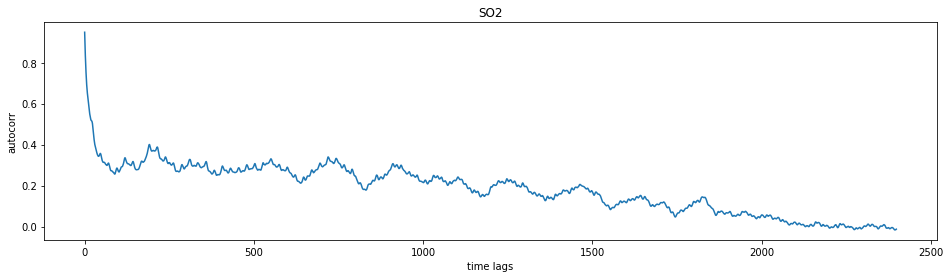

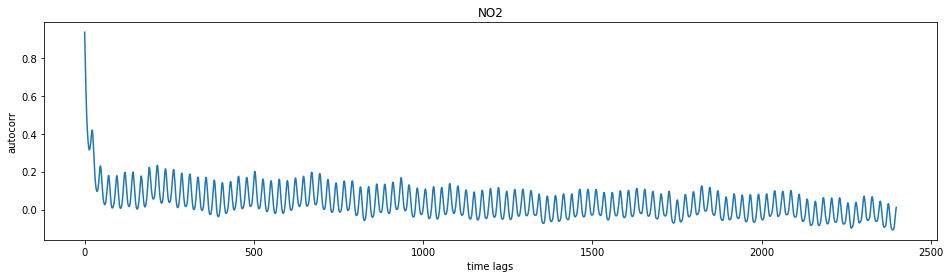

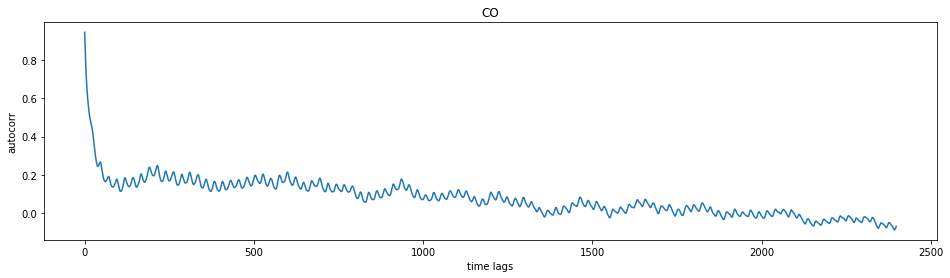

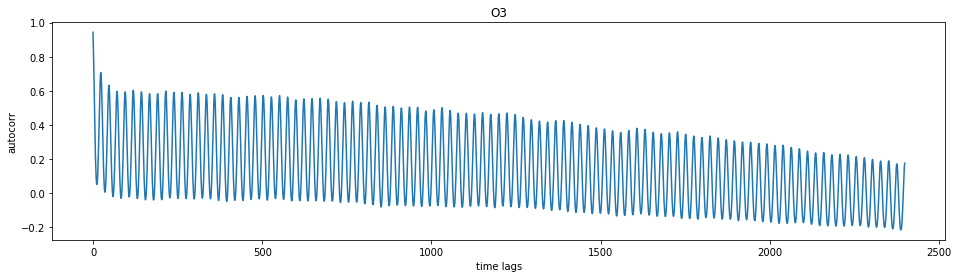

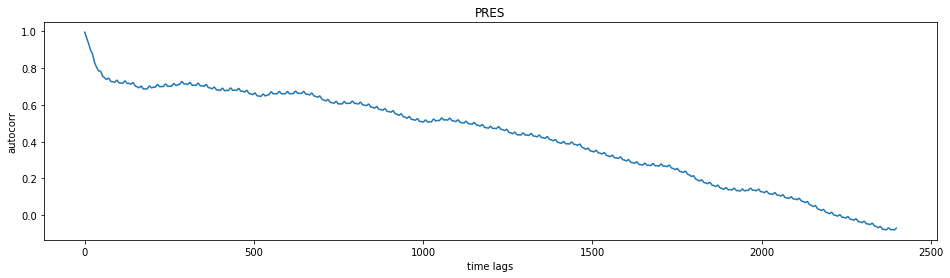

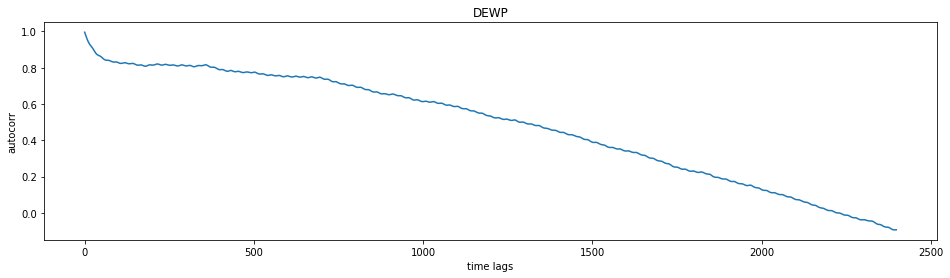

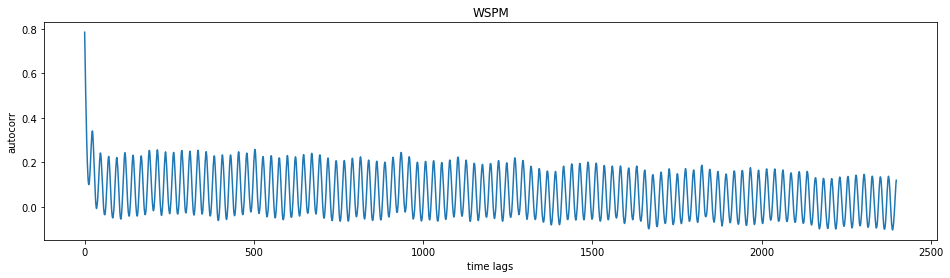

In [ ]:
### PLOT AUTOCORRELATION ###

for col in df.columns:
    plot_autocor(col, train)

In [ ]:
### FIND BEST VAR ORDER ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in tqdm(range(1,100)):
    model = VAR(endog=train.values)
    model_result = model.fit(maxlags=i)
    AIC[i] = model_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER:', best_order, 'BEST AIC:', best_aic)

100%|██████████| 99/99 [03:17<00:00,  1.99s/it]

BEST ORDER: 50 BEST AIC: 37.82893603956663


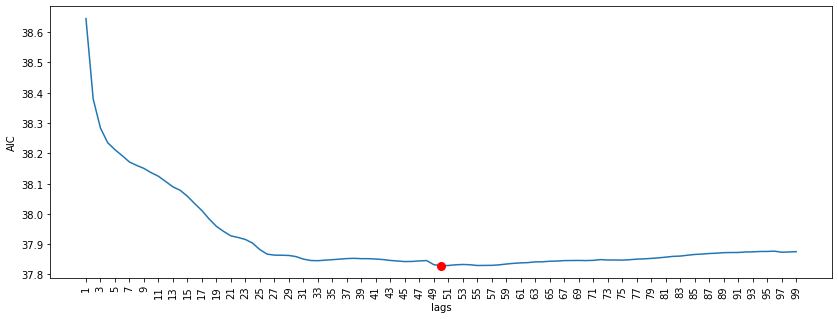

In [ ]:
### PLOT AICs ### 

plt.figure(figsize=(14,5))
plt.plot(range(len(AIC)), list(AIC.values()))
plt.plot([best_order-1], [best_aic], marker='o', markersize=8, color="red")
plt.xticks(range(0,len(AIC), 2), range(1,100, 2), rotation=90)
plt.xlabel('lags'); plt.ylabel('AIC')
np.set_printoptions(False)

In [ ]:

### FIT FINAL VAR WITH LAG CORRESPONTING TO THE BEST AIC ###

var = VAR(endog=train.values)
var_result = var.fit(maxlags=best_order)
var_result.aic

37.82893603956663

In [ ]:
### UTILITY FUNCTIONS FOR NEURAL NETWORK TRAINING ###


def create_windows(data, window_shape, step = 1, start_id = None, end_id = None):
    
    data = np.asarray(data)
    data = data.reshape(-1,1) if np.prod(data.shape) == max(data.shape) else data
        
    start_id = 0 if start_id is None else start_id
    end_id = data.shape[0] if end_id is None else end_id
    
    data = data[int(start_id):int(end_id),:]
    window_shape = (int(window_shape), data.shape[-1])
    step = (int(step),) * data.ndim
    slices = tuple(slice(None, None, st) for st in step)
    indexing_strides = data[slices].strides
    win_indices_shape = ((np.array(data.shape) - window_shape) // step) + 1
    
    new_shape = tuple(list(win_indices_shape) + list(window_shape))
    strides = tuple(list(indexing_strides) + list(data.strides))
    
    window_data = np.lib.stride_tricks.as_strided(data, shape=new_shape, strides=strides)
    
    return np.squeeze(window_data, 1)


def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)


def get_model(param, look_ahead, look_back):
    
    set_seed(33)
    
    opt = Adam()
    opt.lr = param['lr']
        
    inp = Input(shape=(look_back, 18))
    
    x = LSTM(param['units_lstm'], activation='relu')(inp)
    x = RepeatVector(look_ahead)(x)
    x = LSTM(param['units_lstm'], activation='relu', 
             return_sequences=True)(x)
    out = TimeDistributed(Dense(9))(x)
    
    model = Model(inp, out)
    model.compile(optimizer=opt, loss='mse')
    
    return model


def get_model_finetune(param, kgs, look_ahead, look_back):
    
    set_seed(33)
    
    best_model_config = get_model(kgs.best_params, look_ahead, look_back)
    best_model_config.set_weights(kgs.best_model.get_weights())
    
    best_model_config.optimizer.lr = param['lr']
    
    return best_model_config

In [ ]:
### DEFINE GRIDS FOR HYPERPARAM TUNING ###

param_grid = {
    'units_lstm': [128, 96, 64], 
    'lr': [7e-4, 1e-3, 3e-3], 
    'epochs': 200, 
    'batch_size': [512, 1024]
}

param_grid_finetune = {
    'lr': stats.loguniform(1e-5, 0.025), 
    'epochs': 200, 
}

In [ ]:
### GET TRAIN VALIDATION AND TEST DATA FOR NEURAL NETWORK ###

y_train = train.iloc[best_order:].values
y_train_var = var_result.fittedvalues

X_train = np.concatenate([
    train.iloc[best_order:].values, train_ext.iloc[best_order:].values], axis=1)
X_train_var = np.concatenate([
    var_result.fittedvalues, train_ext.iloc[best_order:].values], axis=1)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, shuffle=False, train_size=0.8)
X_train_var, X_val_var, y_train_var, y_val_var = train_test_split(
    X_train_var, y_train_var, shuffle=False, train_size=0.8)

y_test = test.values
X_test = np.concatenate([test.values, test_ext.values], axis=1)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_var.shape, X_val_var.shape)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_var.shape, y_val_var.shape)


(22400, 18) (5601, 18) (7013, 18)
(22400, 18) (5601, 18)
(22400, 9) (5601, 9) (7013, 9)
(22400, 9) (5601, 9)


In [ ]:
### SCALE DATA ###

scaler = StandardScaler()
scaler_y = StandardScaler()
scaler_var = StandardScaler()
scaler_y_var = StandardScaler()

y_train = scaler_y.fit_transform(y_train)
y_val = scaler_y.transform(y_val)

y_train_var = scaler_y_var.fit_transform(y_train_var)
y_val_var = scaler_y_var.transform(y_val_var)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_var = scaler_var.fit_transform(X_train_var)
X_val_var = scaler_var.transform(X_val_var)

In [ ]:

look_back = 24*2
look_ahead = 6

X_train = create_windows(X_train, window_shape = look_back, end_id = -look_ahead)
y_train = create_windows(y_train, window_shape = look_ahead, start_id = look_back)
X_train_var = create_windows(X_train_var, window_shape = look_back, end_id = -look_ahead)
y_train_var = create_windows(y_train_var, window_shape = look_ahead, start_id = look_back)

X_val = create_windows(X_val, window_shape = look_back, end_id = -look_ahead)
y_val = create_windows(y_val, window_shape = look_ahead, start_id = look_back)
X_val_var = create_windows(X_val_var, window_shape = look_back, end_id = -look_ahead)
y_val_var = create_windows(y_val_var, window_shape = look_ahead, start_id = look_back)

X_test = create_windows(X_test, window_shape = look_back, end_id = -look_ahead)
y_test = create_windows(y_test, window_shape = look_ahead, start_id = look_back)

print(X_train.shape, X_val.shape, X_test.shape)
print(X_train_var.shape, X_val_var.shape)

print(y_train.shape, y_val.shape, y_test.shape)
print(y_train_var.shape, y_val_var.shape)

(22347, 48, 18) (5548, 48, 18) (6960, 48, 18)
(22347, 48, 18) (5548, 48, 18)
(22347, 6, 9) (5548, 6, 9) (6960, 6, 9)
(22347, 6, 9) (5548, 6, 9)


In [ ]:
### FIT WITH HYPERPARAM TUNING ON VAR FITTED VALUES ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, look_ahead=look_ahead, look_back=look_back)  

kgs_var = KerasGridSearch(hypermodel, param_grid, 
                          monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs_var.search(X_train_var, y_train_var, validation_data=(X_val_var, y_val_var), callbacks=[es])


18 trials detected for ('units_lstm', 'lr', 'epochs', 'batch_size')

***** (1/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 0.3888 at epoch 12

***** (2/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.40027 at epoch 6

***** (3/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 512})
SCORE: 0.34451 at epoch 3

***** (4/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.37227 at epoch 3

***** (5/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 0.38349 at epoch 3

***** (6/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.3892 at epoch 8

***** (7/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 0.3575 at epoch 5

***** (8/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'batch

<kerashypetune.KerasGridSearch>

In [ ]:
### FIT WITH HYPERPARAM TUNING ON RAW VALUES (AFTER THE TRAIN ON VAR FITTED VALUES) ###

es = EarlyStopping(patience=10, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model_finetune(param=x, kgs=kgs_var, look_ahead=look_ahead, look_back=look_back)  

krs_ft = KerasRandomSearch(hypermodel, param_grid_finetune, n_iter=20, sampling_seed=33,
                           monitor='val_loss', greater_is_better=False, tuner_verbose=1)
krs_ft.search(X_train, y_train, batch_size=kgs_var.best_params['batch_size'], 
              validation_data=(X_val, y_val), callbacks=[es])


20 trials detected for ('lr', 'epochs')

***** (1/20) *****
Search({'lr': 0.0003857635118975211, 'epochs': 200})
SCORE: 0.38636 at epoch 1

***** (2/20) *****
Search({'lr': 0.0005714173878534292, 'epochs': 200})
SCORE: 0.38358 at epoch 1

***** (3/20) *****
Search({'lr': 7.740755538615648e-05, 'epochs': 200})
SCORE: 0.37418 at epoch 8

***** (4/20) *****
Search({'lr': 0.0016506606834983432, 'epochs': 200})
SCORE: 0.39337 at epoch 1

***** (5/20) *****
Search({'lr': 0.0028975199561219536, 'epochs': 200})
SCORE: 0.40207 at epoch 3

***** (6/20) *****
Search({'lr': 7.456687844809637e-05, 'epochs': 200})
SCORE: 0.37361 at epoch 8

***** (7/20) *****
Search({'lr': 0.0009501006290131641, 'epochs': 200})
SCORE: 0.39299 at epoch 1

***** (8/20) *****
Search({'lr': 1.8215739071153037e-05, 'epochs': 200})
SCORE: 0.37619 at epoch 24

***** (9/20) *****
Search({'lr': 3.052974383613633e-05, 'epochs': 200})
SCORE: 0.3764 at epoch 8

***** (10/20) *****
Search({'lr': 9.772977050450925e-05, 'epochs':

TypeError: ignored

In [ ]:
pred_lstm_var = krs_ft.best_model.predict(X_test)
pred_lstm_var = scaler_y.inverse_transform(pred_lstm_var.reshape(-1, pred_lstm_var.shape[-1])).reshape(pred_lstm_var.shape)


In [ ]:
### FIT WITH HYPERPARAM TUNING ON RAW VALUES ###

es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

hypermodel = lambda x: get_model(param=x, look_ahead=look_ahead, look_back=look_back)  

kgs = KerasGridSearch(hypermodel, param_grid, 
                      monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train_var, y_train_var, validation_data=(X_val_var, y_val_var), callbacks=[es])



18 trials detected for ('units_lstm', 'lr', 'epochs', 'batch_size')

***** (1/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 0.3888 at epoch 12

***** (2/18) *****
Search({'units_lstm': 128, 'lr': 0.0007, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.40027 at epoch 6

***** (3/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 512})
SCORE: 0.34451 at epoch 3

***** (4/18) *****
Search({'units_lstm': 128, 'lr': 0.003, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.37227 at epoch 3

***** (5/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 512})
SCORE: 0.38349 at epoch 3

***** (6/18) *****
Search({'units_lstm': 128, 'lr': 0.001, 'epochs': 200, 'batch_size': 1024})
SCORE: 0.3892 at epoch 8

***** (7/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'batch_size': 512})
SCORE: 0.3575 at epoch 5

***** (8/18) *****
Search({'units_lstm': 64, 'lr': 0.0007, 'epochs': 200, 'batch

<kerashypetune.KerasGridSearch>

In [ ]:
### OBTAIN PREDICTIONS ###

pred_lstm = kgs.best_model.predict(X_test)
pred_lstm = scaler_y.inverse_transform(pred_lstm.reshape(-1, pred_lstm.shape[-1])).reshape(pred_lstm.shape)


In [ ]:
### COMPUTE METRICS ON TEST DATA ###

error_lstm, error_var_lstm = {}, {}
error_baseline = {}

for i,col in enumerate(df.columns):
    
    error = mean_squared_error(y_test[...,i], pred_lstm[...,i])
    error_lstm[col] = np.sqrt(error)
    
    error = mean_squared_error(y_test[...,i], pred_lstm_var[...,i])
    error_var_lstm[col] = np.sqrt(error)
    
    error = mean_squared_error(y_test[1:,:,i], np.repeat(y_test[:-1,[0],i], look_ahead, axis=1))
    error_baseline[col] = np.sqrt(error)

print(error_lstm)
print(error_var_lstm)
print(error_baseline)

{'PM2.5': 43.86698154863042, 'PM10': 56.713623018586034, 'SO2': 9.306980481641762, 'NO2': 23.56629074275888, 'CO': 713.5230268046514, 'O3': 33.22223171070802, 'PRES': 2.3939610477777302, 'DEWP': 3.464140274175642, 'WSPM': 0.8876273765020635}
{'PM2.5': 44.16579011455523, 'PM10': 52.25012447433044, 'SO2': 9.990104976990803, 'NO2': 22.187436477006745, 'CO': 692.3561850189734, 'O3': 35.98117819832624, 'PRES': 2.5152163565995536, 'DEWP': 3.28116949706448, 'WSPM': 0.8856544886222747}
{'PM2.5': 42.791536954863425, 'PM10': 50.197228111998605, 'SO2': 8.159125593782795, 'NO2': 24.52404037799615, 'CO': 723.9160599463968, 'O3': 46.17669059448969, 'PRES': 1.7648824686968636, 'DEWP': 2.6397481191072663, 'WSPM': 1.0123458204499831}


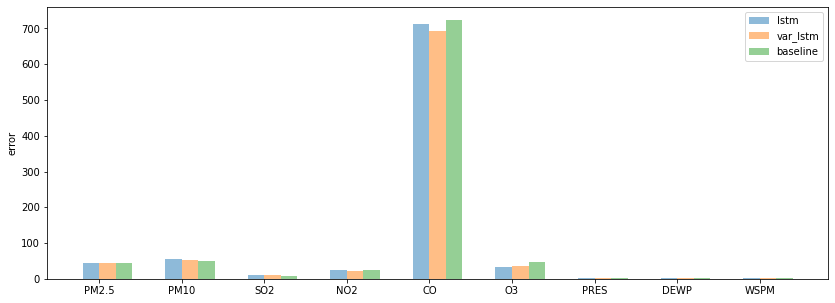

In [ ]:

plt.figure(figsize=(14,5))
plt.bar(np.arange(len(error_lstm))-0.1, error_lstm.values(), 
        alpha=0.5, width=0.2, label='lstm')
plt.bar(np.arange(len(error_var_lstm))+0.1, error_var_lstm.values(), 
        alpha=0.5, width=0.2, label='var_lstm')
plt.bar(np.arange(len(error_baseline))+0.3, error_baseline.values(), 
        alpha=0.5, width=0.2, label='baseline')
plt.xticks(range(len(error_lstm)), error_lstm.keys())
plt.ylabel('error'); plt.legend()
np.set_printoptions(False)


In [ ]:
### COMPUTE METRICS ON TEST DATA ###
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

error_lstm, error_var_lstm = {}, {}
error_baseline = {}

for i,col in enumerate(df.columns):
    
    error = mean_squared_error(y_test[...,i], pred_lstm[...,i])
    error_lstm[col] = error
    
    error = mean_squared_error(y_test[...,i], pred_lstm_var[...,i])
    error_var_lstm[col] = error
    
    error = mean_squared_error(y_test[1:,:,i], np.repeat(y_test[:-1,[0],i], look_ahead, axis=1))
    error_baseline[col] = error

print(error_baseline)

In [ ]:
### COMPUTE METRICS ON TEST DATA ###
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

error_lstm, error_var_lstm = {}, {}
error_baseline = {}

for i,col in enumerate(df.columns):
    
    error = mean_absolute_error(y_test[...,i], pred_lstm[...,i])
    error_lstm[col] = error
    
    error = mean_absolute_error(y_test[...,i], pred_lstm_var[...,i])
    error_var_lstm[col] = error
    
    error = mean_absolute_error(y_test[1:,:,i], np.repeat(y_test[:-1,[0],i], look_ahead, axis=1))
    error_baseline[col] = error


print(error_lstm)
print(error_var_lstm)
print(error_baseline)

In [ ]:
### COMPUTE METRICS ON TEST DATA ###
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

error_lstm, error_var_lstm = {}, {}
error_baseline = {}

for i,col in enumerate(df.columns):
    
    error = mean_squared_error(y_test[...,i], pred_lstm[...,i])
    error_lstm[col] = error
    
    error = mean_squared_error(y_test[...,i], pred_lstm_var[...,i])
    error_var_lstm[col] = error
    
    error = mean_squared_error(y_test[1:,:,i], np.repeat(y_test[:-1,[0],i], look_ahead, axis=1))
    error_baseline[col] = error


print(error_lstm)
print(error_var_lstm)
print(error_baseline)

In [ ]:
print(error_baseline)

In [ ]:
### COMPUTE METRICS ON TEST DATA ###
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

error_lstm, error_var_lstm = {}, {}
error_baseline = {}

for i,col in enumerate(df.columns):
    
    error = mean_absolute_error(y_test[...,i], pred_lstm[...,i])
    error_lstm[col] = error
    
    error = mean_absolute_error(y_test[...,i], pred_lstm_var[...,i])
    error_var_lstm[col] = error
    
    error = mean_absolute_error(y_test[1:,:,i], np.repeat(y_test[:-1,[0],i], look_ahead, axis=1))
    error_baseline[col] = error

print(error_lstm)
print(error_var_lstm)
print(error_baseline)

In [ ]:
sequence_length = 24*2

def gen_sequence(id_df, seq_length, seq_cols):

    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [ ]:
X_train, X_val, X_test = [], [], []

for sequence in gen_sequence(x_train, sequence_length, columns):
    X_train.append(sequence)
    
for sequence in gen_sequence(x_val, sequence_length, columns):
    X_val.append(sequence)
    
for sequence in gen_sequence(x_test, sequence_length, columns):
    X_test.append(sequence)
    
X_train, X_val, X_test = np.asarray(X_train), np.asarray(X_val), np.asarray(X_test)
print(X_train.shape, X_val.shape, X_test.shape)

In [ ]:
def scale_target(y, mean, std):
    return (y - mean)/std

def reverse_target(pred, mean, std): 
    return pred*std + mean

In [ ]:
mean_train = y_train.mean()
std_train = y_train.std()

y_train_seq = scale_target(y_train[sequence_length:], mean_train, std_train)
y_val_seq = scale_target(y_val[sequence_length:], mean_train, std_train)
y_test_seq = scale_target(y_test[sequence_length:], mean_train, std_train)

print(y_train_seq.shape, y_val_seq.shape, y_test_seq.shape)

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1,len(columns))).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1,len(columns))).reshape(X_val.shape)
X_test = scaler.transform(X_test.reshape(-1,len(columns))).reshape(X_test.shape)

In [ ]:
### DEFINE MODEL ###

def set_seed(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def get_model(params):
    
    set_seed(33)
    
    inp = Input(shape=(sequence_length, len(columns)))

    x = GRU(params['units_gru'], return_sequences=True)(inp)
    x = AveragePooling1D(2)(x)
    x = Conv1D(params['units_cnn'], 3, 
               activation='relu', padding='same', 
               name='extractor')(x)
    x = Flatten()(x)
    out = Dense(1)(x)
    
    model = Model(inp, out)
    model.compile(optimizer=Adam(lr=params['lr']), loss='mse')
    
    return model

In [ ]:
param_grid = {
    'units_gru': [128, 64],
    'units_cnn': [64, 32],
    'lr': [1e-4, 1e-3],
    'batch_size': [512, 1024]
}

es = EarlyStopping(patience=5, verbose=1, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)
kgs = KerasGridSearch(get_model, param_grid, 
                      monitor='val_loss', greater_is_better=False, tuner_verbose=1)
kgs.search(X_train, y_train_seq, validation_data=(X_val, y_val_seq), callbacks=[es], epochs=50)

In [ ]:
### MAKE PREDICTION ON TEST ###

pred = reverse_target(kgs.best_model.predict([X_test]).ravel(), mean_train, std_train)

In [ ]:
pred.shape

In [ ]:
print(pred)

In [ ]:
print(X_test)

In [ ]:
### PREDICTIONS vs REALITY ON TEST ###

plt.figure(figsize=(16,6))

start, end = 0, 3000
plt.plot(test_date[sequence_length+start:end+sequence_length], y_test[sequence_length+start:end+sequence_length], 
         c='orange', label='real test')
plt.plot(test_date[sequence_length+start:end+sequence_length], pred[start:end], 
         c='green', label='prediction')
plt.legend(); plt.ylabel('PM2.5')
plt.show()





In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

print(np.sqrt(mean_squared_error(y_test[sequence_length+start:end+sequence_length],pred[start:end])))
print(mean_squared_error(y_test[sequence_length+start:end+sequence_length],pred[start:end]))
print(mean_absolute_error(y_test[sequence_length+start:end+sequence_length],pred[start:end]))
print(r2_score(y_test[sequence_length+start:end+sequence_length],pred[start:end]))


In [ ]:
model.history

In [ ]:
### PREDICTIONS vs REALITY ON TEST ###



start, end = 0, 3000
print(mean_squared_error(test_date[sequence_length+start:end+sequence_length], y_test[sequence_length+start:end+sequence_length]))

        

In [ ]:
### PREDICTIONS vs REALITY ON TEST ###



start, end = 0, 3000
qqq =test_date[sequence_length+start:end+sequence_length]
www= y_test[sequence_length+start:end+sequence_length]

        

In [ ]:
qqq

In [ ]:
www

In [ ]:
print(test_date)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

print(mean_squared_error(pred, y_test_seq))

In [ ]:
### DEFINE MODEL ###


    
inp = Input(shape=(sequence_length, len(columns)))

x = GRU(128, return_sequences=True)(inp)
x = AveragePooling1D(2)(x)
x = Conv1D(64, 3,  activation='relu', padding='same', name='extractor')(x)
x = Flatten()(x)
out = Dense(1)(x)
    
model = Model(inp, out)
model.compile(optimizer=Adam(lr=0.01), loss='mse')
    

In [ ]:
df['2013-03-01']['PM2.5'].mean()

In [ ]:
df['PM2.5'].fillna(method='ffill', inplace=True)
df['PM2.5'].fillna(value=df['2013-03-01']['PM2.5'].mean(), inplace=True)
df.head()

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 6

def plot_pred_date(pred):
    pred = pd.DataFrame(sc.inverse_transform(pred), columns=df.columns, index=valid.index)
    temp = pd.DataFrame(sc.inverse_transform(train), columns=train.columns, index=train.index)
    
    for col in temp.columns:
        plt.plot(temp[col], 'r-', label='Actual Data')
        plt.plot(pred[col], 'b-', label='Predicted Data')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.title(f'Predicted {col} vs DateTime')
        plt.show()
        
    return


def plot_actual_pred(pred):
    pred = pd.DataFrame(sc.inverse_transform(pred), columns=df.columns, index=valid.index)
    temp = pd.DataFrame(sc.inverse_transform(valid), columns=valid.columns, index=valid.index)

    for col in temp.columns:
        plt.plot(temp[col], 'r-', label='Actual Data')
        plt.plot(pred[col], 'b-', label='Predicted Data')
        plt.legend()
        plt.xlabel('Date')
        plt.ylabel(col)
        plt.title(f'Actual {col} vs Predicted {col}')
        plt.show()
        
    return

In [ ]:
d_train = df[:int(0.7*(len(df)))]
d_valid = df[int(0.7*(len(df))):]

In [ ]:
sc = StandardScaler()
sc.fit(d_train)
train = pd.DataFrame(sc.transform(d_train), columns=df.columns, index=d_train.index)
valid = pd.DataFrame(sc.transform(d_valid), columns=df.columns, index=d_valid.index)

In [ ]:
n_input = len(train.columns)
n_features= len(train.columns)
generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=10)
test_data = np.vstack((train[-n_input:], valid.values))
valid_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=len(test_data))

In [ ]:
d_train = df[:int(0.7*(len(df)))]
d_valid = df[int(0.7*(len(df))):]


sc = StandardScaler()
sc.fit(d_train)
train = pd.DataFrame(sc.transform(d_train), columns=df.columns, index=d_train.index)
valid = pd.DataFrame(sc.transform(d_valid), columns=df.columns, index=d_valid.index)



n_input = len(train.columns)
n_features= len(train.columns)
generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=10)
test_data = np.vstack((train[-n_input:], valid.values))
valid_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=len(test_data))


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam





lstm_model = tf.keras.Sequential()
lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True), input_shape=(n_input, n_features)))
lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True)))
lstm_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, activation='relu')))
lstm_model.add(tf.keras.layers.Dense(11))
lstm_model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

lstm_model.summary()



In [ ]:

history = lstm_model.fit_generator(generator,epochs=40)

In [ ]:
losses_lstm = lstm_model.history.history['loss']

plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = train[-n_input:]
current_batch = batch.values.reshape((1, n_input, n_features))

for i in range(len(valid)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]], axis=1)



predictions = lstm_model.predict_generator(valid_generator)
predictions.shape, valid.shape

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
lstm_pred = pd.DataFrame(predictions, columns=df.columns)

#check rmse
for i in df.columns:
    try:
        print('RMSE value for', i, 'is : ', np.sqrt(mean_squared_error(lstm_pred[i], valid[i])))
        print('MSE value for', i, 'is : ', (mean_squared_error(lstm_pred[i], valid[i])))
        print('MAE value for', i, 'is : ', (mean_absolute_error(lstm_pred[i], valid[i])))
        print('R2 value for', i, 'is : ', (r2_score(lstm_pred[i], valid[i])))
    except Exception as err:
        print(i, err)

In [ ]:
plot_pred_date(lstm_pred)

In [ ]:
plot_actual_pred(lstm_pred)

In [ ]:
d_train = df[:int(0.7*(len(df)))]
d_valid = df[int(0.7*(len(df))):]


sc = StandardScaler()
sc.fit(d_train)
train = pd.DataFrame(sc.transform(d_train), columns=df.columns, index=d_train.index)
valid = pd.DataFrame(sc.transform(d_valid), columns=df.columns, index=d_valid.index)



n_input = len(train.columns)
n_features= len(train.columns)
generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=10)
test_data = np.vstack((train[-n_input:], valid.values))
valid_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=len(test_data))


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam

lstm_model = Sequential()
lstm_model.add(LSTM(500, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(100, activation='relu'))
lstm_model.add(Dense(11))
lstm_model.compile(RMSprop(lr=1e-06), loss='mse' )

lstm_model.summary()



In [ ]:

history = lstm_model.fit_generator(generator,epochs=40)

In [ ]:
losses_lstm = lstm_model.history.history['loss']

plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = train[-n_input:]
current_batch = batch.values.reshape((1, n_input, n_features))

for i in range(len(valid)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]], axis=1)



predictions = lstm_model.predict_generator(valid_generator)
predictions.shape, valid.shape


from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
lstm_pred = pd.DataFrame(predictions, columns=df.columns)

#check rmse
for i in df.columns:
    try:
        print('RMSE value for', i, 'is : ', np.sqrt(mean_squared_error(lstm_pred[i], valid[i])))
        print('MSE value for', i, 'is : ', (mean_squared_error(lstm_pred[i], valid[i])))
        print('MAE value for', i, 'is : ', (mean_absolute_error(lstm_pred[i], valid[i])))
        print('R2 value for', i, 'is : ', (r2_score(lstm_pred[i], valid[i],  multioutput='variance_weighted')))
    except Exception as err:
        print(i, err)
   

In [ ]:
plot_pred_date(lstm_pred)

In [ ]:
plot_actual_pred(lstm_pred)

In [ ]:
d_train = df[:int(0.7*(len(df)))]
d_valid = df[int(0.7*(len(df))):]


sc = StandardScaler()
sc.fit(d_train)
train = pd.DataFrame(sc.transform(d_train), columns=df.columns, index=d_train.index)
valid = pd.DataFrame(sc.transform(d_valid), columns=df.columns, index=d_valid.index)



n_input = len(train.columns)
n_features= len(train.columns)
generator = TimeseriesGenerator(train.values, train.values, length=n_input, batch_size=10)
test_data = np.vstack((train[-n_input:], valid.values))
valid_generator = TimeseriesGenerator(test_data, test_data, length=n_input, batch_size=len(test_data))


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, RMSprop, Adam

lstm_model = Sequential()
lstm_model.add(LSTM(500, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
lstm_model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
lstm_model.add(Dense(100, activation='relu'))
lstm_model.add(Dense(11))
lstm_model.compile(Adam(lr=1e-01), loss='mse' )

lstm_model.summary()



In [ ]:

history = lstm_model.fit_generator(generator,epochs=10)

In [ ]:
losses_lstm = lstm_model.history.history['loss']

plt.figure(figsize=(12,4))
plt.xticks(np.arange(0,21,1))
plt.plot(range(len(losses_lstm)),losses_lstm);

In [ ]:
lstm_predictions_scaled = list()

batch = train[-n_input:]
current_batch = batch.values.reshape((1, n_input, n_features))

for i in range(len(valid)):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred)
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]], axis=1)



predictions = lstm_model.predict_generator(valid_generator)
predictions.shape, valid.shape


from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
lstm_pred = pd.DataFrame(predictions, columns=df.columns)

#check rmse
for i in df.columns:
    try:
        print('RMSE value for', i, 'is : ', np.sqrt(mean_squared_error(lstm_pred[i], valid[i])))
        print('MSE value for', i, 'is : ', (mean_squared_error(lstm_pred[i], valid[i])))
        print('MAE value for', i, 'is : ', (mean_absolute_error(lstm_pred[i], valid[i])))
        print('R2 value for', i, 'is : ', (r2_score(lstm_pred[i], valid[i],  multioutput='variance_weighted')))
    except Exception as err:
        print(i, err)
   

In [ ]:
plot_pred_date(lstm_pred)

In [ ]:
plot_actual_pred(lstm_pred)